# Document Similarity Search API
This API finds documents similar to a given document (by ID) within and across specified indices (e.g., patents, publications), returning the most similar results and their similarity scores.


In [2]:
from dotenv import dotenv_values
import pandas as pd
import requests


# Load environment variables from .env file
conf = dotenv_values()
API_KEY = conf["API_KEY"]

In [ ]:
# API Settings
URL = 'https://api.logic-mill.net/api/v1/graphql/'
headers = {
    'content-type': 'application/json',
    'Authorization': 'Bearer ' + API_KEY,
}

# Build the GraphQL query
query = """query SimilaritySearch($index: String!, $id: String!, $amount: Int, $indices: [String], $model: String!) { SimilaritySearch(index: $index id: $id amount: $amount indices: $indices model: $model) { id score index document { title url PatspecterEmbedding } } }"""

# Build variables
variables = {
  "model": "patspecter",
  "amount": 25,
  "id": "91081326",
  "index": "patents",
  "indices": [
    "patents",
    "publications"
  ]
}

In [17]:
# Send a POST request to the API
response = requests.post(URL, headers=headers, json={'query': query , 'variables': variables})

In [18]:
# Handle response
if not response.ok:
    raise Exception(f"Error: {response.status_code} - {response.text}")

json_response = response.json()
documents = json_response["data"]["SimilaritySearch"]
df = pd.json_normalize(documents)
df

,id,index,score,document.PatspecterEmbedding,document.title,document.url
0,43862061,patents,0.998581,"[0.21646596, -0.0036251752, -0.06423303, 0.635...","Wireless electronic oil tank lock, wireless el...",https://worldwide.espacenet.com/patent/search?...
1,76869202,patents,0.988037,"[0.35616955, 0.13733153, -0.23826171, 1.038214...",Oil larceny prevention supervisory system for ...,https://worldwide.espacenet.com/patent/search?...
2,78076165,patents,0.987582,"[0.23847537, 0.14707802, -0.21069725, 1.070719...",Oil larceny prevention supervisory system for ...,https://worldwide.espacenet.com/patent/search?...
3,67449168,patents,0.987456,"[0.31045374, -0.21497293, -0.2197614, 0.795946...",System and method for monitoring oil mass of s...,https://worldwide.espacenet.com/patent/search?...
4,67229230,patents,0.986441,"[-0.00047669807, -0.18292755, -0.47558445, 0.6...",Intelligent turnout external locking refueling...,https://worldwide.espacenet.com/patent/search?...
5,71425071,patents,0.985943,"[0.17744556, -0.061677467, 0.15340298, 1.06394...",Skid-mounted refueling device based on Interne...,https://worldwide.espacenet.com/patent/search?...
6,82025502,patents,0.985588,"[0.04980893, 0.14687276, -0.12845017, 1.009740...",Full-automatic refueling system,https://worldwide.espacenet.com/patent/search?...
7,74369545,patents,0.985041,"[0.20738418, 0.0027670108, 0.2575576, 1.046409...",Skid-mounted refueling device based on Interne...,https://worldwide.espacenet.com/patent/search?...
8,73969714,patents,0.984944,"[0.27563527, 0.43641186, 0.032683365, 0.803781...",RFID self-service refueling system,https://worldwide.espacenet.com/patent/search?...
9,57146653,patents,0.984941,"[0.028162815, 0.26613486, -0.88516146, 0.78537...",VEHICLE REFUELING SYSTEM AND METHOD USING FUEL...,https://worldwide.espacenet.com/patent/search?...


In [19]:
df['id'].to_list()

['43862061',
 '76869202',
 '78076165',
 '67449168',
 '67229230',
 '71425071',
 '82025502',
 '74369545',
 '73969714',
 '57146653',
 '57469748',
 '62037466',
 '46923612',
 '58957114',
 '65687486',
 '45763988',
 '72541150',
 '80381853',
 '64832149',
 '54515038',
 '73886102',
 '74361472',
 '57715629',
 '80603978',
 '88142590',
 'W2239104564',
 'W1491977392',
 'W2920795379',
 'W1990752804',
 'W3109137065',
 'W4392255776',
 'W2060393918',
 'W2369854543',
 'W2349548809',
 'W2598577335',
 'W1978044984',
 'W2067235459',
 'W2377370932',
 'W4324137448',
 'W4392389309',
 'W2378865504',
 'W2809757245',
 'W3019325769',
 'W2117041438',
 'W4236662228',
 'W2167224711',
 'W4362718225',
 'W2364777665',
 'W2079788930',
 'W4392883972']

## Word Cloud

The following visualization displays a word cloud generated from the titles of the most similar documents found by the Document Similarity Search API. Each word's size in the cloud is weighted by the similarity score of the document(s) in which it appears, giving greater prominence to words from more relevant documents.

To enhance clarity, common trivial words (stopwords) are removed. The color palette used is 'viridis', which provides a modern and visually appealing gradient. This approach helps to quickly identify the most significant and frequent terms among the top similar documents.

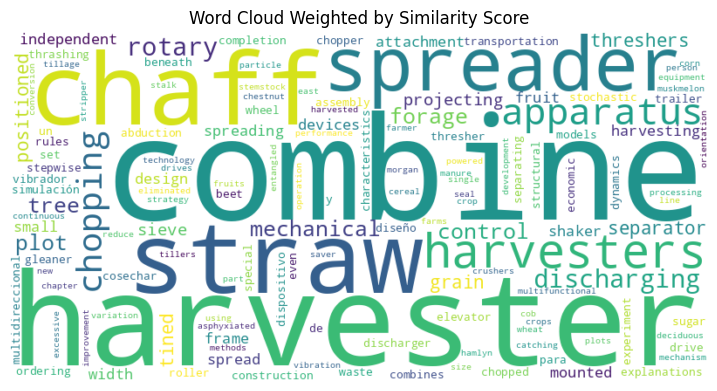

In [15]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter

# Combine all titles, weighted by their similarity score
texts = df['document.title'].fillna('').tolist()
scores = df['score'].tolist()

# Tokenize, lower, and remove trivial words (stopwords)
stopwords = set(STOPWORDS)
word_freq = Counter()

for title, score in zip(texts, scores):
    words = [w.lower() for w in title.split()]
    words = [w for w in words if w.isalpha() and w not in stopwords]
    for w in words:
        word_freq[w] += score  # Weight by similarity score

# Generate the word cloud
wc = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords, colormap='viridis')
wc.generate_from_frequencies(word_freq)

# Plot
plt.figure(figsize=(9, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Weighted by Similarity Score')
plt.show()